In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cheat_score(model, val):
    print("RMSLE sub: " + str(rmsle(model.predict(val), np.log1p(cheat["SalePrice"]))))


def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')


def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))


data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

#X_train, y_train = remove_outliers_split(X_train, y_train)
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train, False)
X_test = transformer.transform(X_test, False)

Int64Index([523, 1298], dtype='int64')


In [58]:
num_features = np.where(X_train.loc[:, X_train.columns.values].dtypes != "object")[0]
X_train = X_train.iloc[:, num_features]
X_test = X_test.iloc[:, num_features]

In [59]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_porch_sf
1353,50.0,56.000000,14720.0,8.0,5.0,1995.0,579.0,816.0,0.0,1217.0,...,283.0,86.0,0.0,0.0,0.0,0.0,0.0,5271.0,4054.0,369.0
737,60.0,72.000000,10463.0,8.0,5.0,2005.0,0.0,0.0,0.0,893.0,...,0.0,116.0,0.0,0.0,0.0,0.0,0.0,2694.0,1801.0,116.0
1014,20.0,60.000000,11664.0,6.0,5.0,1948.0,206.0,336.0,0.0,746.0,...,0.0,130.0,0.0,0.0,0.0,0.0,0.0,2164.0,1418.0,130.0
903,20.0,50.000000,14859.0,7.0,5.0,2006.0,27.0,0.0,0.0,1670.0,...,144.0,60.0,0.0,0.0,0.0,0.0,0.0,3340.0,1670.0,204.0
1160,160.0,24.000000,2280.0,6.0,5.0,1978.0,0.0,311.0,0.0,544.0,...,26.0,0.0,0.0,0.0,0.0,0.0,0.0,2311.0,1767.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,20.0,108.315898,6853.0,8.0,5.0,2001.0,136.0,1005.0,0.0,262.0,...,192.0,25.0,0.0,0.0,0.0,0.0,0.0,2563.0,2301.0,217.0
1289,60.0,86.000000,11065.0,8.0,5.0,2006.0,788.0,0.0,0.0,1085.0,...,177.0,74.0,0.0,0.0,0.0,0.0,0.0,3055.0,1970.0,251.0
180,160.0,70.999273,2117.0,6.0,5.0,2000.0,456.0,436.0,0.0,320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2281.0,1961.0,0.0
1291,160.0,21.000000,1680.0,5.0,7.0,1972.0,268.0,231.0,0.0,399.0,...,185.0,0.0,0.0,0.0,0.0,0.0,0.0,1932.0,1533.0,185.0


In [60]:
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

evaluate(clf, X_train, y_train)
evaluate(clf, X_test, y_test)

RMSLE: 0.12549784715362078
RMSLE: 0.12763892439720836


In [79]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X, False)

num_features = np.where(X.loc[:, X.columns.values].dtypes != "object")[0]

validation = pd.read_csv("./test.csv")
raw_val = validation.copy()
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)
validation = transformer.transform(validation, False)

X = X.iloc[:, num_features]
validation = validation.iloc[:, num_features]

Int64Index([523, 1298], dtype='int64')


In [80]:
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

evaluate(clf, X, y)

sub_predictions = clf.predict(validation)
print("RMSLE submission: " + str(rmsle(sub_predictions, np.log1p(cheat["SalePrice"]))))

RMSLE: 0.1257516790350755
RMSLE submission: 0.1461998310214446


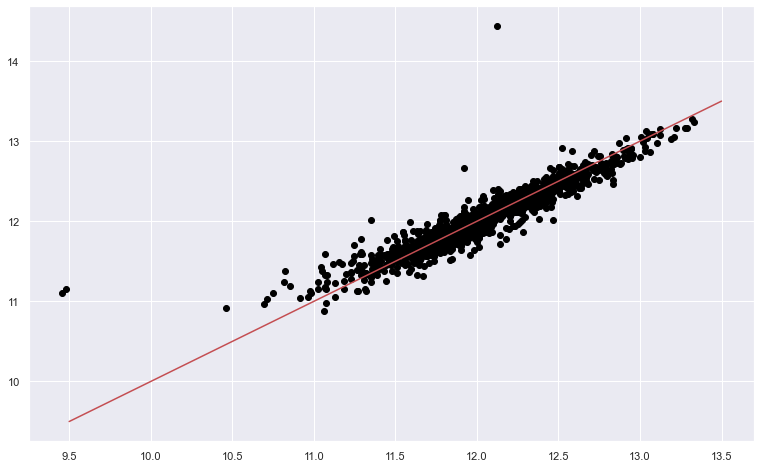

In [81]:
plt.figure(figsize=(13,8))
plt.scatter(np.log1p(cheat["SalePrice"]), sub_predictions, color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

In [82]:
outlier_id = np.where(np.log1p(cheat["SalePrice"]) < 10)[0]
validation.loc[outlier_id]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,Total_sqr_footage,Total_porch_sf
76,30.0,68.0,9656.0,2.0,2.0,1923.0,0.0,0.0,0.0,678.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1510.0,832.0,0.0
756,20.0,80.0,14584.0,1.0,5.0,1952.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,733.0,733.0,0.0


In [83]:
raw_val

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
